In [1]:
# Install neccesary packages
!pip install biopython sparse

# Download ProPedia structures
!wget http://bioinfo.dcc.ufmg.br/propedia2/public/download/complex2_3.zip

# Download ProPedia sequences
!wget http://bioinfo.dcc.ufmg.br/propedia2/public/download/sequences2_3.zip

# Unzip
!unzip -qq /content/complex2_3.zip
!unzip -qq /content/sequences2_3.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 9.6 MB/s eta 0:00:00
--2024-11-16 17:45:38--  http://bioinfo.dcc.ufmg.br/propedia2/public/download/complex2_3.zip
Resolving bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)... 150.164.203.91
Connecting to bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)|150.164.203.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2524597712 (2.4G) [application/zip]
Saving to: ‘complex2_3.zip’

complex2_3.zip      100%[===================>]   2.35G  21.3MB/s    in 1m 55s  

2024-11-16 17:47:33 (20.9 MB/s) - ‘complex2_3.zip’ saved [2524597712/2524597712]

--2024-11-16 17:47:33--  http://bioinfo.dcc.ufmg.br/propedia2/public/download/sequences2_3.zip
Resolving bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)... 150.164.203.91
Connecting to bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)|150.164.203.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [2]:
#@title Generate sequence/contact data

# Collect as many sequences as possible from propedia
# Get their sequences and contact maps

import os
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt

# For storing data
proteins = []
peptides = []
contacts = np.zeros((100_000, 52, 770))

# Important parameters
CUTOFF = 12.0
maxPepLen = 50
maxProLen = 768
failed = 0

with os.scandir('./complex') as it:
  for entry in tqdm(it):
    if entry.name.endswith(".pdb") and entry.is_file():
        # Extract pdb id and chains
        id, pepchain, prochain = entry.name.split('.')[0].split('_')

        # Get peptide sequence
        for record in SeqIO.parse(f"./peptide/{id}_{pepchain}.fasta", "fasta"):
          pep_seq = str(record.seq)

        # Get protein sequence
        for record in SeqIO.parse(f"./receptor/{id}_{prochain}.fasta", "fasta"):
          pro_seq = str(record.seq)

        # Skip non-canonical amino acids, invalid lengths, etc
        if 'X' in pep_seq or 'X' in pro_seq or len(pro_seq) > maxProLen:
          continue

        # Get pdb
        parser = PDBParser()
        structure = parser.get_structure('pdb', f'./complex/{entry.name}')
        pep_chain = structure[0][pepchain]
        pro_chain = structure[0][prochain]

        # Select chains
        pep_residues = [r for r in pep_chain.get_residues()]
        rec_residues = [r for r in pro_chain.get_residues()]

        # Skip if pdb sequence length is not fasta sequence len
        if len(list(pep_chain.get_residues())) != len(pep_seq): continue
        if len(list(pro_chain.get_residues())) != len(pro_seq): continue

        # Get binary contact matrix
        try:
          distances = np.zeros((maxPepLen, maxProLen))
          for x in range(min(len(pep_seq), maxPepLen)):
            for y in range(min(len(pro_seq), maxProLen)):
              one = pep_residues[x]['CA'].get_coord()
              two = rec_residues[y]['CA'].get_coord()
              d = np.linalg.norm(one-two)
              if d <= CUTOFF:
                distances[x, y] = 1
              else:
                distances[x, y] = 0
        except:
          failed += 1
          # print(f'{failed} failed')
          # print(f'{len(peptides)} succeeded')
          # print(f'{contacts.sum()} total contacts')
          continue

        # Pad the out side of the matrix with 0's (to account for bos/eos)
        distances = np.pad(distances, 1, 'constant', constant_values=(0))

        if len(pro_seq) <= maxProLen and distances.sum() > 0:
          peptides.append(pep_seq)
          proteins.append(pro_seq)
          contacts[len(peptides)-1] = distances

49297it [32:47, 25.05it/s]


In [3]:
contacts = contacts[:len(peptides)]
print(len(peptides))
print(len(proteins))
contacts.shape

17287
17287


(17287, 52, 770)

In [4]:
# Remove duplicate peptide/protein pairs.
import sparse
import pandas as pd
df = pd.DataFrame({
    'sequence': peptides,
    'receptor': proteins,
    'contacts': list(range(contacts.shape[0]))
})
df = df.drop_duplicates(subset=["sequence", "receptor"]).reset_index()
contacts = contacts[df['contacts'].tolist()]

proteins = df['receptor'].tolist()
peptides = df['sequence'].tolist()

print(len(proteins))
print(len(peptides))
print(contacts.shape)

11186
11186
(11186, 52, 770)


In [5]:
#@title SAVE
# Save the sequence pairs and the val indices.
with open('11_15pairs.txt', 'w') as f:
  for i, pair in enumerate(zip(peptides, proteins)):
    p, P = pair
    f.write(f'{P}:{p}:{0}\n')
f.close()
np.savez_compressed('11_15contacts.npz', a=contacts)

In [ ]:
#@title If sequence/contact data is already generated, just load it directly
# Load the protein/peptide pairs into lists
import sparse
import numpy as np
proteins = []
peptides = []
with open('/content/8_8_24_sequence_pairs_768.txt', 'r') as f:
  for line in f:
    prot, pep, _ = line.split(':')
    proteins.append(prot.replace('\n', ''))
    peptides.append(pep.replace('\n', ''))
f.close()

# Load the distance matrices for all pairs
sparse_contacts = sparse.load_npz('/content/8_8_24_contacts_768.npz')
sparse_contacts = sparse_contacts[:len(peptides)]
contacts = sparse_contacts.todense()

print(len(peptides))
print(len(proteins))
contacts.shape

In [6]:
# Find the the 10% of interfaces with the lowest
# average similarity to all other interfaces

contacts_flat = contacts.sum(axis=1)

# Normalize embeddings
norms = np.linalg.norm(contacts_flat, axis=1, keepdims=True)
normalized_embeddings = contacts_flat / norms

# Compute cosine similarities matrix
cosine_similarities = np.dot(normalized_embeddings, normalized_embeddings.T)

# Fill the diagonal with NaNs to ignore self-similarity
np.fill_diagonal(cosine_similarities, np.nan)

# Compute the average cosine similarity for each embedding
average_similarities = np.nanmean(cosine_similarities, axis=1)

# Find the indices of the 10% embeddings with the lowest average similarity
# These sequences will become the validation set
num_lowest = int(len(average_similarities) * 0.1)
val_idxs = np.argsort(average_similarities)[:num_lowest]
train_idxs = np.setdiff1d(np.arange(contacts_flat.shape[0]), val_idxs)

In [9]:
# Create a 1d array containing the train/val idxs.
# For now, set all training idxs to -1
all_idxs = np.zeros(contacts.shape[0])
all_idxs[train_idxs] = -1

In [12]:
# Now, remove any sequence pairs that have distance matricies
# with > 0.7 cosine similaity to any distance matrix in the validation set

from tqdm import tqdm
from sklearn.metrics.pairwise import manhattan_distances
from scipy.spatial.distance import cdist

cosine_similarities = 1 - cdist(contacts_flat[train_idxs], contacts_flat[val_idxs], metric='cosine')
max_similarities = np.max(cosine_similarities, axis=1)
train_idxs = train_idxs[np.where(max_similarities <= 0.7)[0]]

print(train_idxs.shape)

(9664,)


In [13]:
# Set the new (smaller subset) of training idxs as 1.
# Now, the final training idxs are set to 1, val idxs are set to 0, a
# and the idxs we will remove are set to -1
all_idxs[train_idxs] = 1

In [16]:
# Save the sequence pairs and the val indices.
final_contacts = []

with open('PepFusionSequencePairs.txt', 'w') as f:
  for i, pair in enumerate(zip(peptides, proteins, all_idxs)):
    p, P, IDX = pair
    if IDX == 1:
      f.write(f'{P}:{p}:{1}\n')
      final_contacts.append(contacts[i])
    elif IDX == 0:
      f.write(f'{P}:{p}:{0}\n')
      final_contacts.append(contacts[i])
f.close()
final_contacts = np.array(final_contacts)

!wc -l PepFusionSequencePairs.txt
print(final_contacts.shape)

10782 PepFusionSequencePairs.txt
(10782, 52, 770)


In [17]:
np.savez_compressed('PepFusionContacts.npz', a=contacts)

In [18]:
negatives = 0
positives = 0
for c, p, P in zip(contacts, peptides, proteins):
  c = c[1:len(p)+1, 1:len(P)+1]
  positives += np.count_nonzero(c)
  negatives += np.count_nonzero(c == 0)
  if c.sum() == 0:
    print(c)
print(positives)
print(negatives)
print(negatives/positives)
print(positives/negatives)
print(1 - (positives/negatives))

1724934
46588207
27.00868960783427
0.03702512097106463
0.9629748790289354


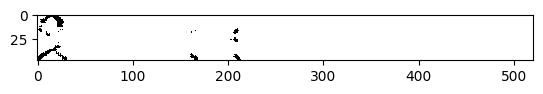

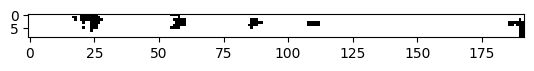

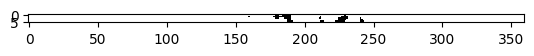

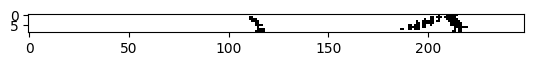

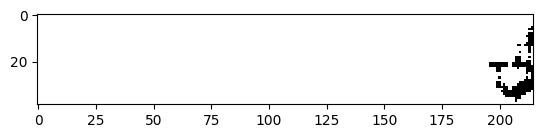

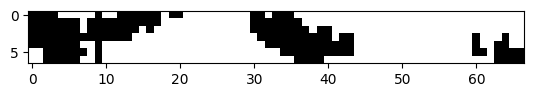

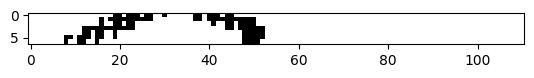

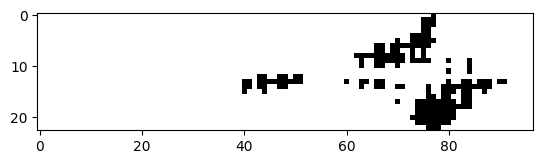

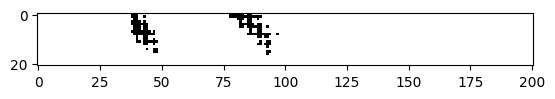

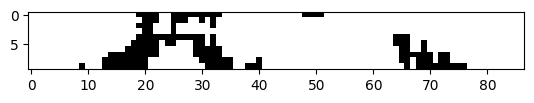

In [22]:
import matplotlib.pyplot as plt

for c, p, P in zip(contacts[:10], peptides[:10], proteins[:10]):
  c = c[1:len(p)+1, 1:len(P)+1]
  plt.imshow(c, cmap='binary', interpolation='nearest')
  plt.show()